## Metrics and evaluation - California Housing

In [1]:
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
x,y = fetch_california_housing(return_X_y=True, as_frame=True)

In [3]:
x.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [4]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


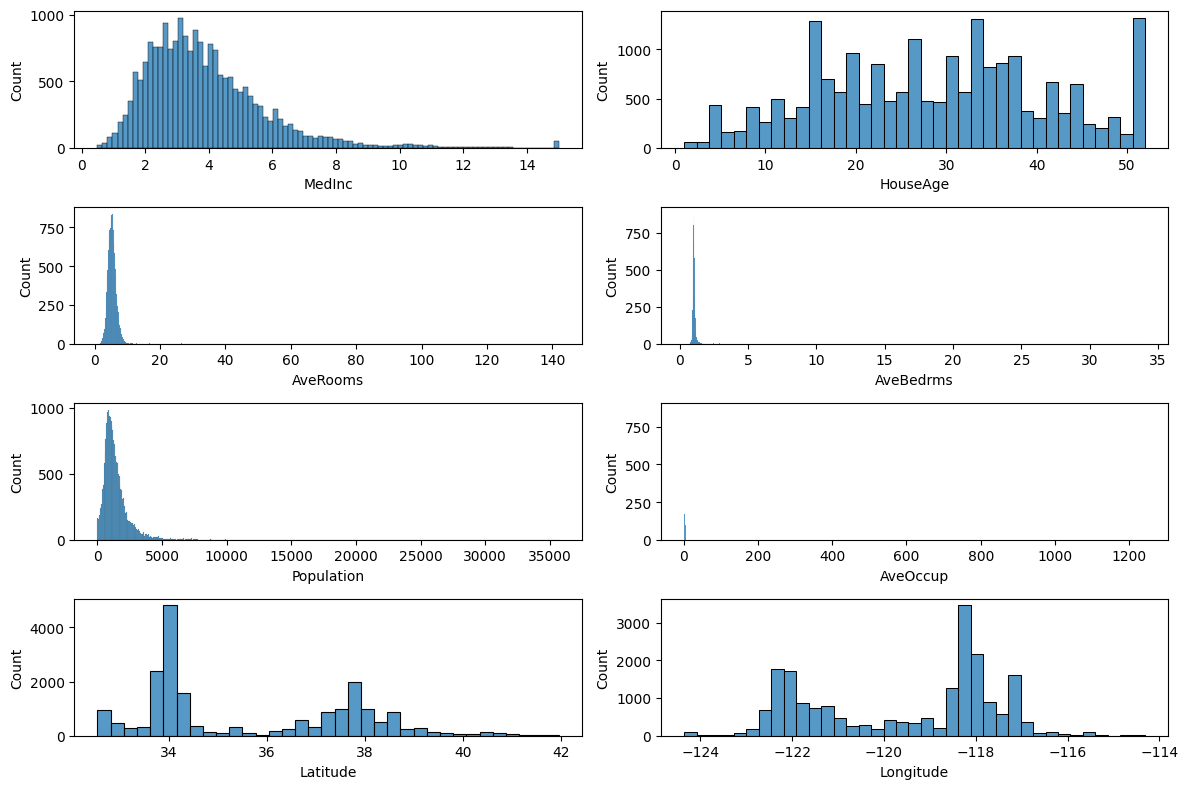

In [5]:
fig, ax = plt.subplots(4,2, figsize=(12,8))

for ax, col in zip(ax.ravel(), x.columns):
    sns.histplot(x[col], ax=ax)

fig.tight_layout()

<Axes: xlabel='Longitude', ylabel='Latitude'>

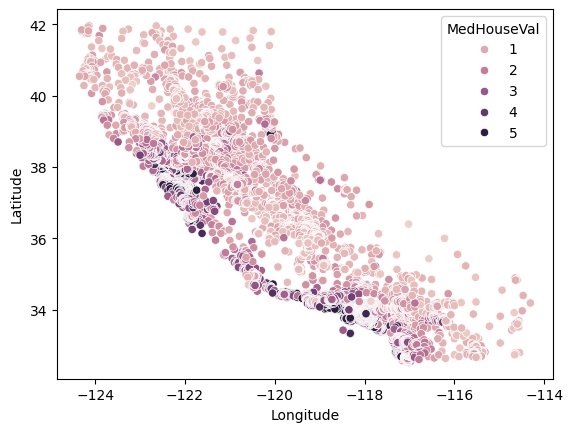

In [6]:
sns.scatterplot(x=x['Longitude'], y=x['Latitude'], hue=y)

<Axes: xlabel='MedHouseVal', ylabel='Count'>

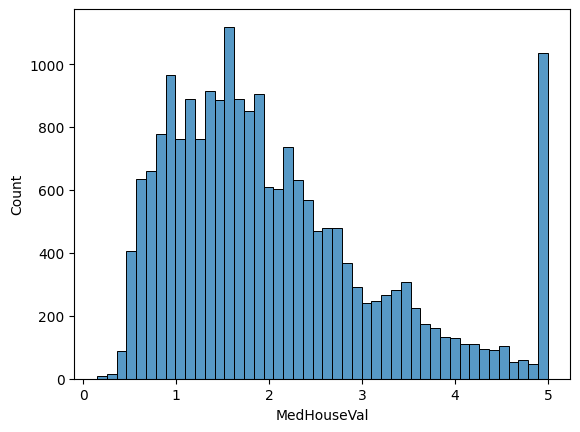

In [7]:
sns.histplot(y)

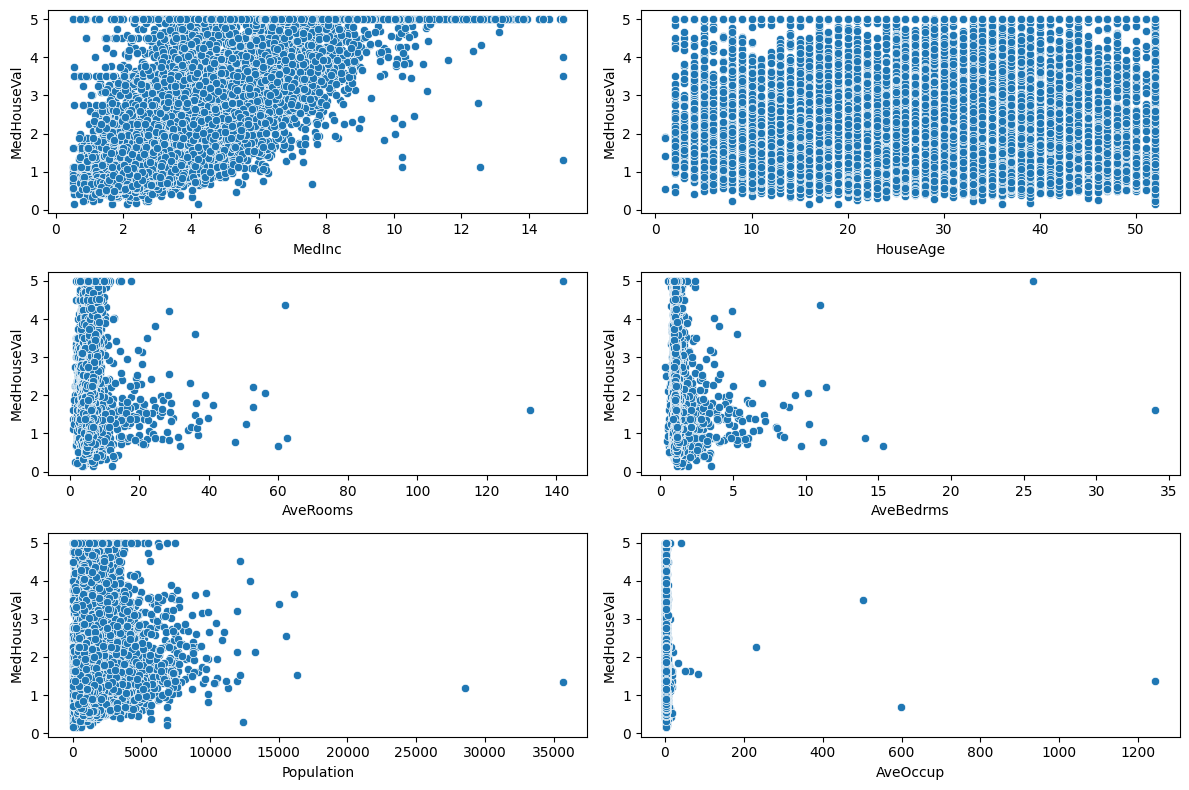

In [8]:
fig, axs = plt.subplots(3,2, figsize=(12,8))

cols = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']

for ax, col in zip(axs.ravel(), cols):
    sns.scatterplot(x=x[col], y=y, ax=ax)

fig.tight_layout()

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_testval, y_train, y_testval = train_test_split(x,y, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_testval, y_testval, test_size=0.5, random_state=42)

In [10]:
Q1 = x_train.quantile(0.25)
Q3 = x_train.quantile(0.75)
IQR = Q3 - Q1

x_train_capped = x_train.copy()
x_test_capped = x_test.copy()
x_val_capped = x_val.copy()

for col in x_train.columns:
    lower_bound = Q1[col] - 1.5 * IQR[col]
    upper_bound = Q3[col] + 1.5 * IQR[col]
    
    x_train_capped[col] = x_train[col].clip(lower=lower_bound, upper=upper_bound)
    x_test_capped[col] = x_test[col].clip(lower=lower_bound, upper=upper_bound)
    x_val_capped[col] = x_val[col].clip(lower=lower_bound, upper=upper_bound)
    
x_train = x_train_capped
x_test = x_test_capped
x_val = x_val_capped

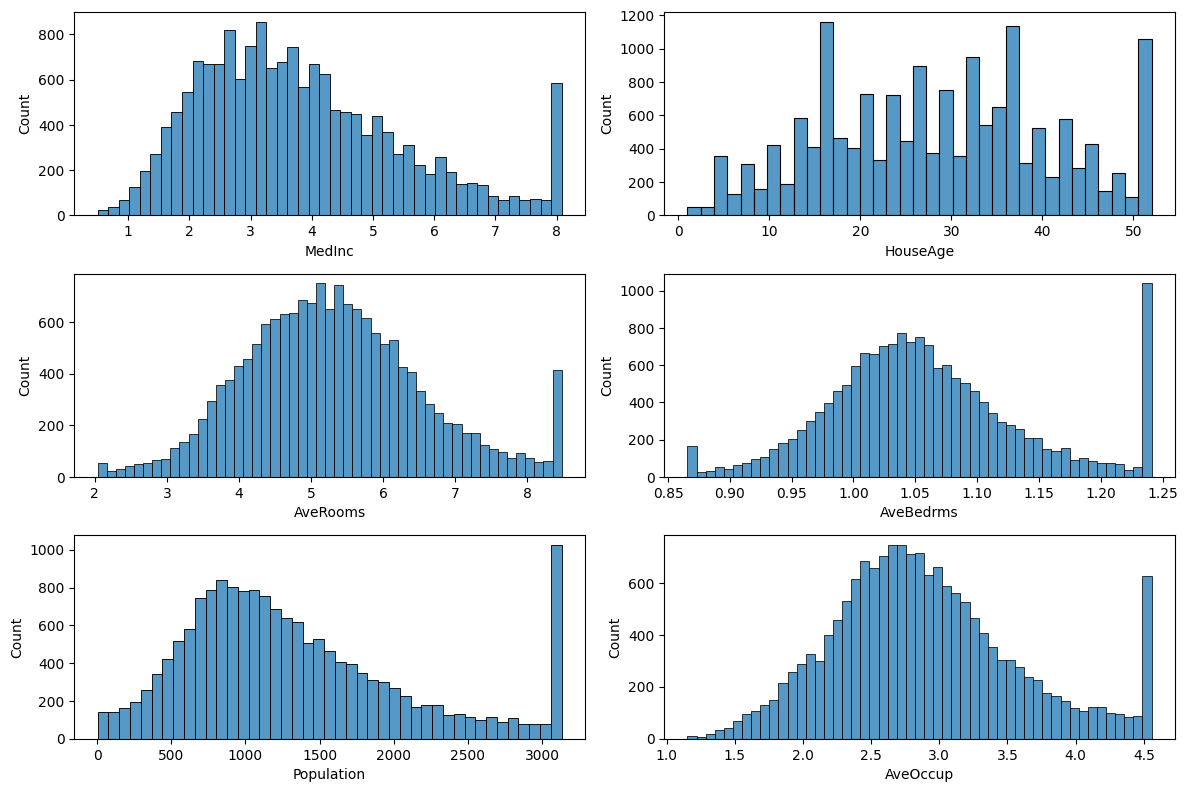

In [11]:
fig, axs = plt.subplots(3,2, figsize=(12,8))

cols = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']

for ax, col in zip(axs.ravel(), cols):
    sns.histplot(x_train[col], ax=ax)

fig.tight_layout()

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

preprocessing = make_pipeline(
    ColumnTransformer([
        ('num', MinMaxScaler(), x_train.columns)
    ])
)

In [13]:
x_train_processed = preprocessing.fit_transform(x_train)
x_test_processed = preprocessing.transform(x_test)
x_val_processed = preprocessing.transform(x_val)

<Axes: ylabel='Count'>

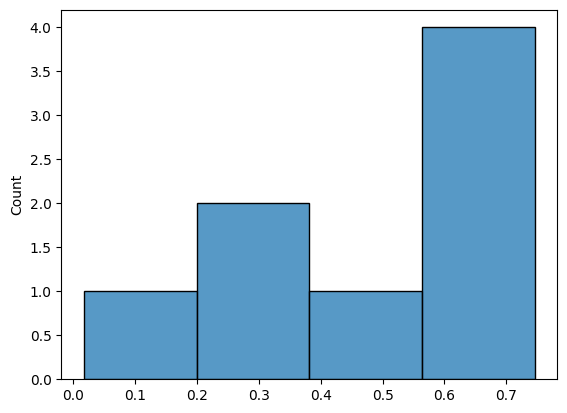

In [14]:
sns.histplot(x_train_processed[0])

## Training and evaluaton

We will create a Linear Regression model and evaluate it using different metrics.

Our main metric will be the Root Mean Squared Error (RMSE).

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
import numpy as np

model = LinearRegression()
model.fit(x_train_processed, y_train)

LinearRegression()

In [16]:
import pandas as pd

def evaluate_model(model, x, y):
    y_pred = model.predict(x)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = root_mean_squared_error(y,y_pred)
    r2 = r2_score(y, y_pred)
    
    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

train_metrics = evaluate_model(model, x_train_processed, y_train)
val_metrics = evaluate_model(model, x_val_processed, y_val)

metrics_df = (pd.DataFrame([train_metrics, val_metrics], index=['Train', 'Validation']))

In [17]:
metrics_df

,MAE,MSE,RMSE,R2
Train,0.492680,0.437935,0.661767,0.672395
Validation,0.502495,0.452564,0.672729,0.652773


In [19]:
from sklearn.ensemble import RandomForestRegressor

m = RandomForestRegressor(n_estimators=1000)

m.fit(x_train_processed, y_train)

_train_metrics = evaluate_model(m, x_train_processed, y_train)
_val_metrics = evaluate_model(m, x_val_processed, y_val)

_metrics_df = (pd.DataFrame([_train_metrics, _val_metrics], index=['Train', 'Validation']))
_metrics_df

,MAE,MSE,RMSE,R2
Train,0.120644,0.034133,0.18475,0.974466
Validation,0.327031,0.255085,0.50506,0.804288


In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

grid_search.fit(x_train_processed, y_train)

GridSearchCV(cv=3, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='neg_root_mean_squared_error')

In [26]:
best_model = grid_search.best_estimator_

best_model_train_metrics = evaluate_model(best_model, x_train_processed, y_train)
best_model_val_metrics = evaluate_model(best_model, x_val_processed, y_val)
best_model_test_metrics = evaluate_model(best_model, x_test_processed, y_test)

best_model_metrics_df = (pd.DataFrame([best_model_train_metrics, best_model_val_metrics, best_model_test_metrics], index=['Train', 'Validation', 'Test']))

best_model_metrics_df

,MAE,MSE,RMSE,R2
Train,0.324142,0.251017,0.501016,0.812222
Validation,0.368070,0.300177,0.547884,0.769691
Test,0.363042,0.309581,0.556400,0.764893


In [27]:
grid_search.best_params_

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

In [20]:
_test_metrics = evaluate_model(m, x_test_processed, y_test)
_test_metrics_df = (pd.DataFrame([_test_metrics], index=['Test']))
_test_metrics_df

,MAE,MSE,RMSE,R2
Test,0.325371,0.246716,0.496705,0.812635
